In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/sub.zip","r")
# zip_ref.extractall("/content")
# zip_ref.close()

In [4]:
# !pip install split-folders

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import os
import glob
import tifffile
from pathlib import Path
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import load_model
#from tensorflow.keras.layers.experimental.preprocessing import ToTensor
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Dropout, Conv2DTranspose, concatenate,Activation,Concatenate,add,multiply
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import sys
from keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# ROOT_DIR ="../sub/38-Cloud_train"

In [7]:
class CloudTestDataset(tf.keras.utils.Sequence):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir):
        self.r_dir = r_dir
        self.g_dir = g_dir
        self.b_dir = b_dir
        self.nir_dir = nir_dir
        self.files = [self.combine_files(f) for f in self.r_dir.iterdir() if not f.is_dir()]

    def combine_files(self, r_file):
        files = {'red': r_file,
                 'green': self.g_dir / r_file.name.replace('red', 'green'),
                 'blue': self.b_dir / r_file.name.replace('red', 'blue'),
                 'nir': self.nir_dir / r_file.name.replace('red', 'nir')}
        return files

    def __len__(self):
        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = np.transpose(raw_rgb, (2, 0, 1))

        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)

    def __getitem__(self, idx):
        x = tf.constant(self.open_as_array(idx, invert=False, include_nir=True), dtype=tf.float32)

        return x

    def generator(self):
        for idx in range(len(self.files)):
            x = self.open_as_array(idx, invert=False, include_nir=True)
            yield x

    def create_tf_dataset(self):
        return tf.data.Dataset.from_generator(
            self.generator,
            output_signature=tf.TensorSpec(shape=x.shape, dtype=tf.float32)
        )

# Replace these paths with the actual paths to your dataset directories
base_test_path = Path('../sub/38-Cloud_test')
test_r_dir = base_test_path / 'test_red'
test_g_dir = base_test_path / 'test_green'
test_b_dir = base_test_path / 'test_blue'
test_nir_dir = base_test_path / 'test_nir'

# Create an instance of your custom TensorFlow test dataset
test_dataset = CloudTestDataset(r_dir=test_r_dir, g_dir=test_g_dir, b_dir=test_b_dir, nir_dir=test_nir_dir)

print(f'length--> {len(test_dataset)}')

# Example usage
for batch in test_dataset:
    x = batch
    print("Shape of input data (x):", x.shape)
    break

length--> 3579
Shape of input data (x): (384, 384, 4)


In [8]:
class CloudDataset(tf.keras.utils.Sequence):

    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir):
        self.r_dir = r_dir
        self.g_dir = g_dir
        self.b_dir = b_dir
        self.nir_dir = nir_dir
        self.gt_dir = gt_dir
        self.files = [self.combine_files(f) for f in self.r_dir.iterdir() if not f.is_dir()]

    def combine_files(self, r_file):
        files = {'red': r_file,
                 'green': self.g_dir / r_file.name.replace('red', 'green'),
                 'blue': self.b_dir / r_file.name.replace('red', 'blue'),
                 'nir': self.nir_dir / r_file.name.replace('red', 'nir'),
                 'gt': self.gt_dir / r_file.name.replace('red', 'gt')}
        return files

    def __len__(self):
        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = np.transpose(raw_rgb, (2, 0, 1))

        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)

    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)

        return np.expand_dims(raw_mask, -1) if add_dims else raw_mask


    def generator(self):
        for idx in range(len(self.files)):
            x = self.open_as_array(idx, invert=False, include_nir=True)
            y = self.open_mask(idx, add_dims=True)  # Ensure that y has shape (384, 384)
            yield x, y

    def create_tf_dataset(self):
        return tf.data.Dataset.from_generator(
            self.generator,
            output_signature=(
                tf.TensorSpec(shape=(None, None, 4), dtype=tf.float32),
                tf.TensorSpec(shape=(None, None, 1), dtype=tf.int64)
            )
        )

    def __getitem__(self, idx):
        x = self.open_as_array(idx, invert=False, include_nir=True)
        y = self.open_mask(idx, add_dims=False)
        return x, y

# Example usage for training dataset
base_path_train = Path('./splited_data/train')
r_dir_train = base_path_train / 'train_red'
g_dir_train = base_path_train / 'train_green'
b_dir_train = base_path_train / 'train_blue'
nir_dir_train = base_path_train / 'train_nir'
gt_dir_train = base_path_train / 'train_gt'

train_dataset = CloudDataset(r_dir=r_dir_train, g_dir=g_dir_train, b_dir=b_dir_train, nir_dir=nir_dir_train, gt_dir=gt_dir_train)
print(f'Training dataset length: {len(train_dataset)}')

# Example usage for getting real image and mask arrays
sample_idx = 0
real_image, real_mask = train_dataset.__getitem__(sample_idx)

print("Shape of real image:", real_image.shape)
print("Shape of real mask:", real_mask.shape)



# Replace these paths with the actual paths to your dataset directories
base_path = Path('./splited_data/val')
r_dir = base_path / 'train_red'
g_dir = base_path / 'train_green'
b_dir = base_path / 'train_blue'
nir_dir = base_path / 'train_nir'
gt_dir = base_path / 'train_gt'

# Create an instance of your custom TensorFlow dataset
val_dataset = CloudDataset(r_dir=r_dir, g_dir=g_dir, b_dir=b_dir, nir_dir=nir_dir, gt_dir=gt_dir)


print(f'val dataset length: {len(val_dataset)}')

# Example usage for getting real image and mask arrays
sample_idx = 0
real_image, real_mask = val_dataset.__getitem__(sample_idx)

print("Shape of real image:", real_image.shape)
print("Shape of real mask:", real_mask.shape)


Training dataset length: 4093
Shape of real image: (384, 384, 4)
Shape of real mask: (384, 384)
val dataset length: 454
Shape of real image: (384, 384, 4)
Shape of real mask: (384, 384)


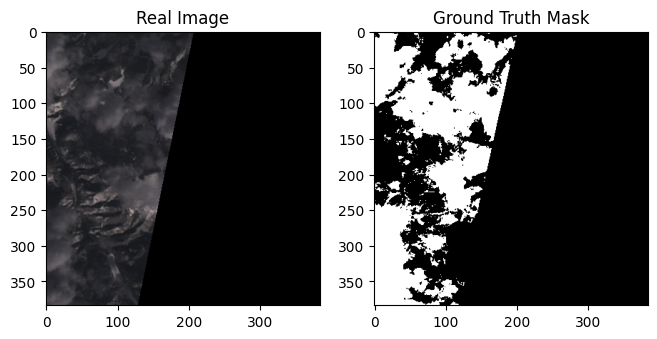

In [9]:
# Get real image and mask
real_image, real_mask = train_dataset.__getitem__(4)
# Plotting
plt.figure(figsize=(12, 4))

# Plot real image
plt.subplot(1, 3, 1)
plt.imshow(real_image[:, :, :3])  # Assuming the first three channels are RGB
plt.title('Real Image')

# Plot ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(real_mask.squeeze(), cmap='gray')
plt.title('Ground Truth Mask')
plt.show()

In [27]:
def jacard_coef_loss(y_true, y_pred):
    return 1 - jacard_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, dtype='float32'))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return intersection / union

In [28]:
def f1_score(y_true, y_pred):
    # Flatten the tensors to 1D arrays
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # Calculate true positives, false positives, and false negatives
    true_positives = K.sum(y_true_flat * K.round(y_pred_flat))
    false_positives = K.sum(K.round(K.clip(y_pred_flat - y_true_flat, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true_flat - y_pred_flat, 0, 1)))

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1


In [12]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch /10) # custom decay
    return exponential_decay_fn

def get_callbacks(num_epochs):
    exponential_decay_fn= exponential_decay(0.0001, num_epochs)

    lr_scheduler = LearningRateScheduler(
        exponential_decay_fn,  # function
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        filepath=os.path.join('./model/unet_{epoch:02d}.h5'),  # Save with epoch number in the filename
        save_weights_only=False,
        monitor='val_loss',
        save_best_only=True,
        mode='auto',
        period=5,  # Save every 5 epochs
        verbose=1,
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=6,
        mode='auto',
        verbose=1,
        restore_best_weights=True
    )

    callbacks = [checkpoint, early_stop, lr_scheduler]

    return callbacks

Simple-Unet

In [13]:
def unet(input_shape, n_filters=32, kernel_size=3, dropout=0.1, batch_norm=True, depth=4):
    skips = []
    input_layer = Input(shape=input_shape,name='image')
    x = input_layer
    # Encoder
    for i in range(depth):
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        skips.append(x)
        if batch_norm:
            x = x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(rate=dropout)(x)
        n_filters = n_filters*2
    
    # Bottleneck
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    if batch_norm:
        x = x = BatchNormalization()(x)
    x = Dropout(rate=dropout)(x)
    
    # Decoder
    for i in reversed(range(depth)):
        n_filters = n_filters//2
        x = Conv2DTranspose(filters=n_filters, kernel_size=3, strides = 2, padding = 'same')(x)
        x = concatenate([x, skips[i]])
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        if batch_norm:
            x = x = BatchNormalization()(x)
        x = Dropout(rate=dropout)(x)
        
    output_layer = Conv2D(1, (1, 1), activation='sigmoid',name='mask')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss={'mask': jacard_coef_loss}, metrics={'mask': [jacard_coef, Precision(), Recall(),f1_score]})
    model.summary()
    return model

In [14]:
input_shape=(384,384,4)
model=unet(input_shape)




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 384, 384, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 384, 384, 32)         1184      ['image[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 384, 384, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 384, 384, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                            

Unet-Attention

In [15]:
def attention2D(inputs, skip_connection):
    theta_x = Conv2D(filters=1, kernel_size=1, activation='relu', padding='same')(inputs)
    phi_skip = Conv2D(filters=1, kernel_size=1, activation='relu', padding='same')(skip_connection)
    
    add_phix_theta_x = add([theta_x, phi_skip])
    
    f = Activation('sigmoid')(add_phix_theta_x)
    rate= Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding='same')(f)
    
    att_x = multiply([rate, skip_connection])
    return att_x


def unet_attn(input_shape, n_filters=32, kernel_size=3, dropout=0.1, batch_norm=True, depth=4):
    skips = []
    input_layer = Input(shape=input_shape,name='image')
    x = input_layer
    # Encoder
    for i in range(depth):
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        skips.append(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(rate=dropout)(x)
        n_filters = n_filters*2
    
    # Bottleneck
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    if batch_norm:
        x = x = BatchNormalization()(x)
    x = Dropout(rate=dropout)(x)
    
    # Decoder
    for i in reversed(range(depth)):
        n_filters = n_filters//2
        x = Conv2DTranspose(filters=n_filters, kernel_size=3, strides = 2, padding = 'same')(x)
        #x = UpSampling2D(size=(2,2)(x)
        att_x = attention2D(x, skips[i])
        x = concatenate([x, att_x])
        
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        if batch_norm:
            x = x = BatchNormalization()(x)
        x = Dropout(rate=dropout)(x)

    output_layer = Conv2D(1, (1, 1), activation='sigmoid',name='mask')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss={'mask': jacard_coef_loss}, metrics={'mask': [jacard_coef, Precision(), Recall(), f1_score]}) #binary_crossentropy
    model.summary()
    return model

In [16]:
input_shape=(384,384,4)
model=unet_attn(input_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 384, 384, 4)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 384, 384, 32)         1184      ['image[0][0]']               
                                                                                                  
 conv2d_19 (Conv2D)          (None, 384, 384, 32)         9248      ['conv2d_18[0][0]']           
                                                                                                  
 batch_normalization_9 (Bat  (None, 384, 384, 32)         128       ['conv2d_19[0][0]']           
 chNormalization)                                                                           

Unet with ASPP

In [17]:
def ASPP(input_tensor, n_filters, kernel_size):
    aspp=[]
    for i in range(3):
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, dilation_rate=6*(i+1), activation='relu', padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        aspp.append(x)
        
    x = Concatenate()(aspp)
    x = Conv2D(filters=n_filters, kernel_size=1, activation='relu', padding='same')(x)
    return x
    
    
def unet_aspp(input_shape, n_filters=32, kernel_size=3, dropout=0.1, batch_norm=True, depth=4):
    skips = []
    input_layer = Input(shape=input_shape,name='image')
    x = input_layer
    # Encoder
    for i in range(depth):
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        skips.append(x)
        if batch_norm:
            x = x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(rate=dropout)(x)
        n_filters = n_filters*2
    
    # Bottleneck
    x = ASPP(x, n_filters, kernel_size=kernel_size)
    
    # Decoder
    for i in reversed(range(depth)):
        n_filters = n_filters//2
        x = Conv2DTranspose(filters=n_filters, kernel_size=3, strides = 2, padding = 'same')(x)
        x = concatenate([x, skips[i]])
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        if batch_norm:
            x = x = BatchNormalization()(x)
        x = Dropout(rate=dropout)(x)
        
    output_layer = Conv2D(1, (1, 1), activation='sigmoid',name='mask')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss={'mask': jacard_coef_loss}, metrics={'mask': [jacard_coef, Precision(), Recall(),f1_score]})
    model.summary()
    return model

In [18]:
input_shape=(384,384,4)
model=unet_aspp(input_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 384, 384, 4)]        0         []                            
                                                                                                  
 conv2d_48 (Conv2D)          (None, 384, 384, 32)         1184      ['image[0][0]']               
                                                                                                  
 conv2d_49 (Conv2D)          (None, 384, 384, 32)         9248      ['conv2d_48[0][0]']           
                                                                                                  
 batch_normalization_18 (Ba  (None, 384, 384, 32)         128       ['conv2d_49[0][0]']           
 tchNormalization)                                                                          

In [ ]:
numEpochs = 50
batch_size = 8

history = model.fit(
    train_dataset.create_tf_dataset().batch(batch_size).repeat(),
    validation_data=val_dataset.create_tf_dataset().batch(batch_size).repeat(),
    epochs=numEpochs,
    steps_per_epoch=50, # len(train_dataset) // batch_size
    validation_steps=50, # len(val_dataset) // batch_size,  # Similarly, calculate validation steps
    callbacks=get_callbacks(numEpochs),
    verbose=1
)

Semi-Supervised Learning using clustering

In [22]:
model_path = './model/unet_dep_3_20.h5'
model = tf.keras.models.load_model(model_path,custom_objects={'jacard_coef_loss': jacard_coef_loss, 'jacard_coef':  jacard_coef,'f1_score':f1_score})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 384, 384, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 384, 384, 32)         1184      ['image[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 384, 384, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 384, 384, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [23]:
input__ = model.get_layer('image').input
output__ =  model.get_layer('dropout_6').output
newmodel= Model(input__,output__)

# Create a new model with input and output layers

newmodel = tf.keras.Model(input__, output__)
n_clusters = 2
# newmodel.summary()

In [24]:
def set_and_plot(real_image, labels_reshaped, pred_mas, real_mask, nodata, i, n_clusters):
    # Cloud Masking
    cloudmasked_real_image = np.where(labels_reshaped == 1, real_image, 0)

    cloud_mean_mask_red = cloudmasked_real_image[np.nonzero(cloudmasked_real_image[:, :, :, 0])].mean()
    cloud_mean_mask_green = cloudmasked_real_image[np.nonzero(cloudmasked_real_image[:, :, :, 1])].mean()
    cloud_mean_mask_blue = cloudmasked_real_image[np.nonzero(cloudmasked_real_image[:, :, :, 2])].mean()
    cloud_mean_mask_nir = cloudmasked_real_image[np.nonzero(cloudmasked_real_image[:, :, :, 3])].mean()

    noncloudmasked_real_image = np.where(labels_reshaped == 0, real_image, 0)

    noncloud_mean_mask_red = noncloudmasked_real_image[np.nonzero(noncloudmasked_real_image[:, :, :, 0])].mean()
    noncloud_mean_mask_green = noncloudmasked_real_image[np.nonzero(noncloudmasked_real_image[:, :, :, 1])].mean()
    noncloud_mean_mask_blue = noncloudmasked_real_image[np.nonzero(noncloudmasked_real_image[:, :, :, 2])].mean()
    noncloud_mean_mask_nir = noncloudmasked_real_image[np.nonzero(noncloudmasked_real_image[:, :, :, 3])].mean()

    print("red ", cloud_mean_mask_red, noncloud_mean_mask_red)
    print("gr ", cloud_mean_mask_green, noncloud_mean_mask_green)
    print("bl ", cloud_mean_mask_blue, noncloud_mean_mask_blue)
    print("nir ", cloud_mean_mask_nir, noncloud_mean_mask_nir)

    swap = False
    # Swap labels if necessary
    if (cloud_mean_mask_red - noncloud_mean_mask_red > 1e-3) and \
       (cloud_mean_mask_green - noncloud_mean_mask_green > 1e-3) and \
       (cloud_mean_mask_blue - noncloud_mean_mask_blue > 1e-3) and \
       (cloud_mean_mask_nir - noncloud_mean_mask_nir > 1e-3):
        pass
    else:
        swap = True
        # Swap labels in the segmented mask
        labels_reshaped = 1 - labels_reshaped

    # Add batch dimension
    nodata = np.expand_dims(nodata, axis=0)
    # Add batch dimension
    nodata = np.expand_dims(nodata, axis=-1)

    labels_reshaped = labels_reshaped * nodata

    rm = tf.cast(real_mask, tf.float32)
    km = tf.cast(labels_reshaped, tf.float32)
    pm = tf.cast(pred_mas, tf.float32)

    jac_error_kmeans = jaccard_coef_loss(rm, km)
    jac_error_pred = jaccard_coef_loss(rm, pm)

    # Plotting
    plt.figure(figsize=(12, 4))

    # Plot real image
    plt.subplot(1, 4, 1)
    # Assuming the first three channels are RGB
    plt.imshow(real_image[0, :, :, :3])
    plt.title('Real Image')

    # Plot predicted mask
    plt.subplot(1, 4, 2)
    # Squeeze to remove single-dimensional entries for visualization
    plt.imshow(labels_reshaped.squeeze(), cmap='gray')
    plt.title(f'{n_clusters}, {swap}' + '-kmeans: {: .3f}'.format(jac_error_kmeans))

    # Plot predicted mask
    plt.subplot(1, 4, 3)
    # Squeeze to remove single-dimensional entries for visualization
    plt.imshow(pred_mas.squeeze(), cmap='gray')
    plt.title('Pred Mask{: .3f}'.format(jac_error_pred))

    # Plot predicted mask
    plt.subplot(1, 4, 4)
    # Squeeze to remove single-dimensional entries for visualization
    plt.imshow(real_mask.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.show()
    plt.close()

In [25]:
def segment_image_and_display(i, train_dataset, model, newmodel, th=0.02):
    # Get real image
    real_image, real_mask = train_dataset.__getitem__(i)

    # NoData Mask
    nodata = np.where(np.logical_and(real_image[..., 0] == 0,
                                     np.logical_and(real_image[..., 1] == 0, np.logical_and(real_image[..., 2] == 0,
                                                                                                   real_image[..., 3] == 0))), 0, 1)

    if np.any(nodata == 0) and np.any(nodata == 1):
        print('if condition\n')
        # Calculate image variability where nodata=1
        image_std = np.std(real_image[nodata == 1])
        # Calculate mean where nodata=1
        image_mean = np.mean(real_image[nodata == 1])
        image_cv = (image_mean / image_std) * 100

        # Perform prediction
        pred_mas = model.predict(np.expand_dims(real_image, axis=0))[0]

        # Add batch dimension
        real_image = np.expand_dims(real_image, axis=0)

        # Perform prediction
        predicted_features = newmodel.predict(real_image)

        # Perform prediction and convert to NumPy array
        predicted_features_np = predicted_features[0]

        # Filter y_pred_reshaped to apply KMeans only to the region where nodata equals 1
        y_pred_reshaped = predicted_features_np[np.where(nodata == 1)]

        print(y_pred_reshaped.shape)

        # Determine the number of clusters based on the threshold
        if image_std >= th:
            n_clusters = 2  # Low variability, predominantly homogeneous
        else:
            n_clusters = 1  # High variability, potentially heterogeneous

        print("std={}  image_mean={}  image_cv={} n_clusters={}".format(image_std, image_mean, image_cv, n_clusters))

        # Apply KMeans
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        labels = kmeans.fit_predict(y_pred_reshaped)

        # Reshape the labels back to the original shape
        labels_reshaped = np.zeros_like(nodata)
        indices = np.where(nodata == 1)
        labels_reshaped[indices] = labels.reshape(-1)

        labels_reshaped = np.expand_dims(labels_reshaped, axis=0)
        labels_reshaped = np.expand_dims(labels_reshaped, axis=-1)

        print('output', labels_reshaped.shape)
 
        set_and_plot(real_image, labels_reshaped, pred_mas, real_mask, nodata, i, n_clusters)

    else:
        print('else condition\n')
        # Calculate image variability
        image_std = np.std(real_image)

        # Calculate mean
        image_mean = np.mean(real_image)

        image_cv = (image_std / image_mean) * 100

        # Perform prediction
        pred_mas = model.predict(np.expand_dims(real_image, axis=0))[0]

        # Add batch dimension
        real_image = np.expand_dims(real_image, axis=0)

        # Perform prediction
        predicted_features = newmodel.predict(real_image)

        # Perform prediction and convert to NumPy array
        predicted_features_np = predicted_features[0]

        # Reshape the predicted_mask_np for k-means clustering
        y_pred_reshaped = predicted_features_np.reshape(-1, predicted_features_np.shape[-1])

        print(y_pred_reshaped.shape)

        # Determine the number of clusters based on the threshold
        if image_std >= th:
            n_clusters = 2  # Low variability, predominantly homogeneous
        else:
            n_clusters = 1  # High variability, potentially heterogeneous

        print("std={}  image_mean={}  image_cv={} n_clusters={}".format(
            image_std, image_mean, image_cv, n_clusters))

        # Apply KMeans
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        labels = kmeans.fit_predict(y_pred_reshaped)

        # Reshape the labels back to the original shape
        labels_reshaped = np.reshape(labels, (1, model.output_shape[1], model.output_shape[2], 1))

        print('output', labels_reshaped.shape)

        set_and_plot(real_image, labels_reshaped, pred_mas, real_mask, nodata, i, n_clusters)

0
else condition

1/1 [==============================] - 1s 546ms/step
(147456, 32)
std=0.026532747971114747  image_mean=0.3058171493025671  image_cv=8.676017035546941 n_clusters=2
output (1, 384, 384, 1)
red  0.3105952835224896 0.30572829615316494
gr  0.3105952835224896 0.30572829615316494
bl  0.3105952835224896 0.30572829615316494
nir  0.3105952835224896 0.30572829615316494


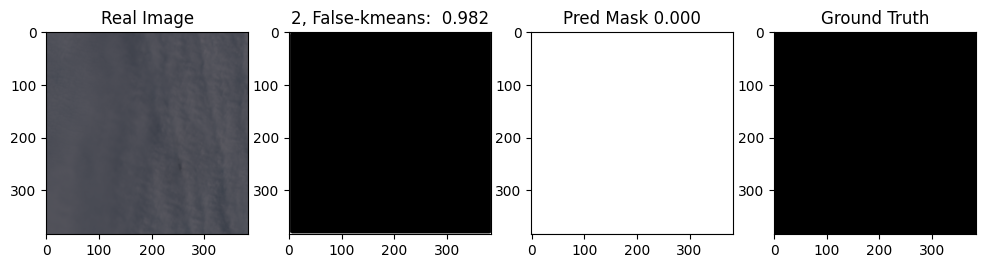

1
else condition

1/1 [==============================] - 0s 159ms/step
(147456, 32)
std=0.1103791939228647  image_mean=0.2422954910356062  image_cv=45.55561205496972 n_clusters=2
output (1, 384, 384, 1)
red  0.19533846531149998 0.32289631478598124
gr  0.19533846531149998 0.32289631478598124
bl  0.19533846531149998 0.32289631478598124
nir  0.19533846531149998 0.32289631478598124


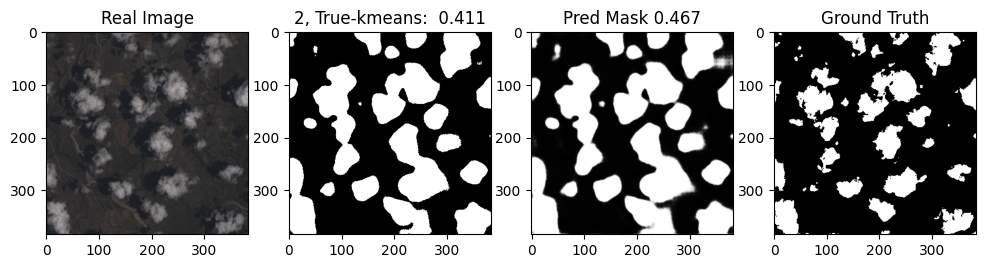

2
else condition

1/1 [==============================] - 0s 155ms/step
(147456, 32)
std=0.13928647086852403  image_mean=0.322656485912782  image_cv=43.16865674480037 n_clusters=2
output (1, 384, 384, 1)
red  0.2539321514974761 0.3246027847520758
gr  0.2539321514974761 0.3246027847520758
bl  0.2539321514974761 0.3246027847520758
nir  0.2539321514974761 0.3246027847520758


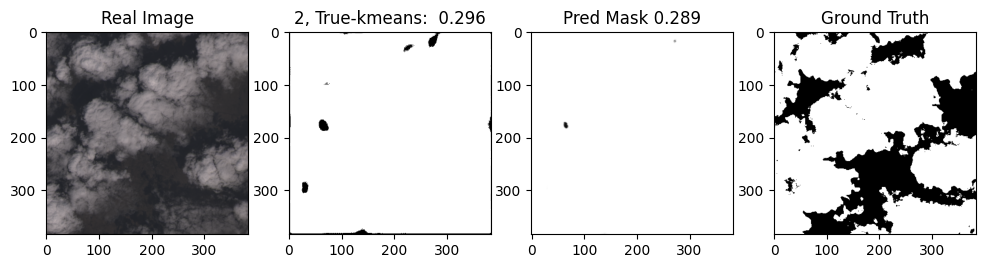

3
if condition

1/1 [==============================] - 0s 153ms/step
(76907, 32)
std=0.14789524511725932  image_mean=0.3181561639752664  image_cv=215.1226455745856 n_clusters=2
output (1, 384, 384, 1)
red  0.19573120980829223 0.34457145057024285
gr  0.19573120980829223 0.34457145057024285
bl  0.19573120980829223 0.34457145057024285
nir  0.19573120980829223 0.34457145057024285


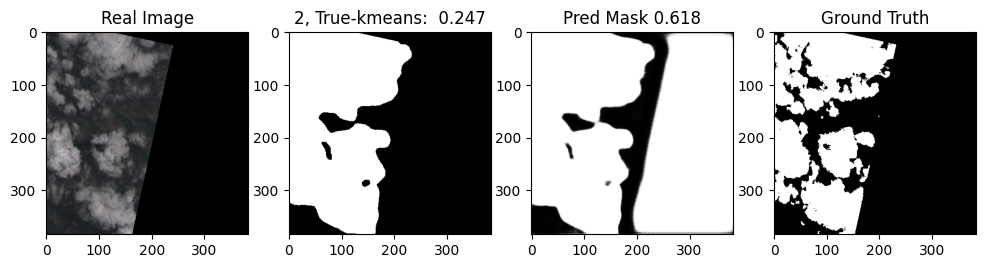

4
if condition

1/1 [==============================] - 0s 153ms/step
(64544, 32)
std=0.08032251309986278  image_mean=0.20267972629621203  image_cv=252.33240155748845 n_clusters=2
output (1, 384, 384, 1)
red  0.24358906205097344 0.17346311811675005
gr  0.24358906205097344 0.17346311811675005
bl  0.24358906205097344 0.17346311811675005
nir  0.24358906205097344 0.17346311811675005


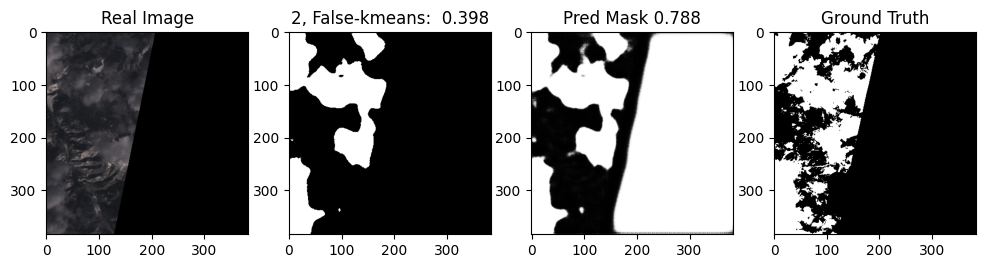

5
if condition

1/1 [==============================] - 0s 190ms/step
(70065, 32)
std=0.021593629795458532  image_mean=0.15400564722102889  image_cv=713.1994420568357 n_clusters=2
output (1, 384, 384, 1)
red  0.1539830918769118 0.1541102106177066
gr  0.1539830918769118 0.1541102106177066
bl  0.1539830918769118 0.1541102106177066
nir  0.1539830918769118 0.1541102106177066


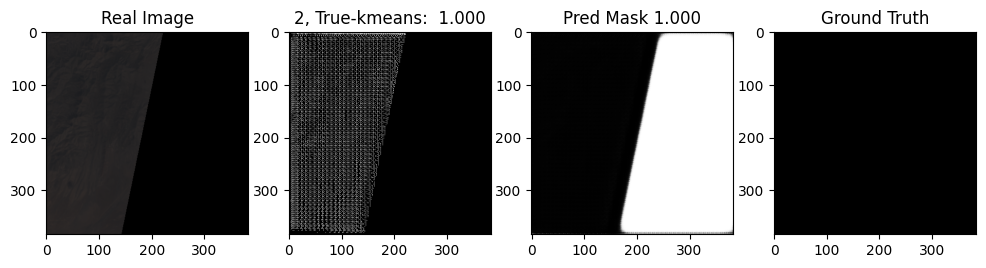

6
else condition

1/1 [==============================] - 0s 166ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


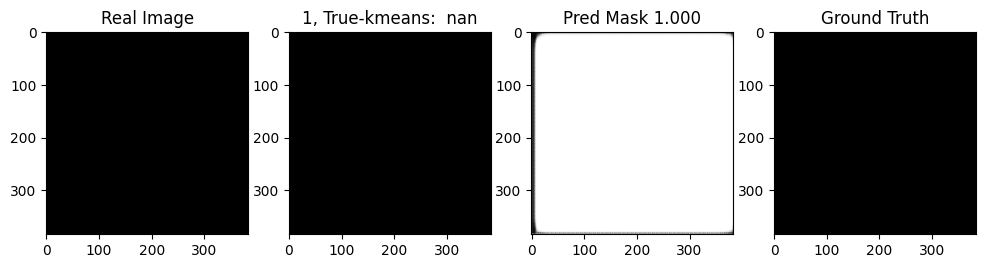

7
else condition

1/1 [==============================] - 0s 183ms/step
(147456, 32)
std=0.008028314658724653  image_mean=0.1366386493190578  image_cv=5.875581102955835 n_clusters=1
output (1, 384, 384, 1)
red  nan 0.1366386493190578
gr  nan 0.1366386493190578
bl  nan 0.1366386493190578
nir  nan 0.1366386493190578


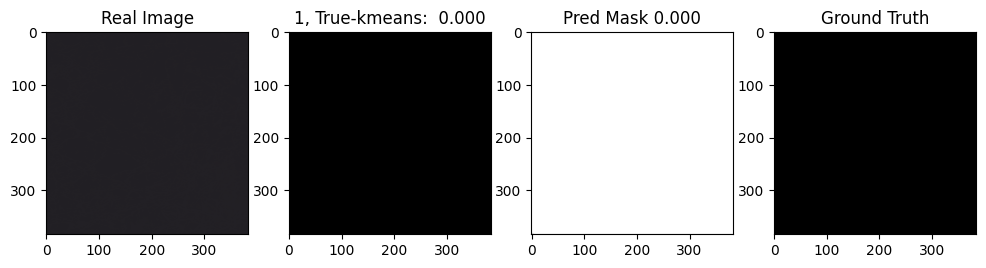

8
else condition

1/1 [==============================] - 0s 162ms/step
(147456, 32)
std=0.029559431891472285  image_mean=0.3228207581736267  image_cv=9.156608161973887 n_clusters=2
output (1, 384, 384, 1)
red  0.32520602958311506 0.32277667068715227
gr  0.32520602958311506 0.32277667068715227
bl  0.32520602958311506 0.32277667068715227
nir  0.32520602958311506 0.32277667068715227


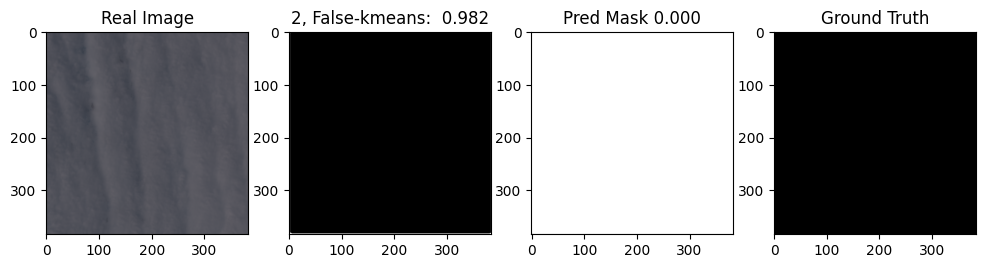

9
else condition

1/1 [==============================] - 0s 156ms/step
(147456, 32)
std=0.106848769860475  image_mean=0.22353188560217252  image_cv=47.80023645066793 n_clusters=2
output (1, 384, 384, 1)
red  0.30237881960874624 0.17756986346222162
gr  0.30237881960874624 0.17756986346222162
bl  0.30237881960874624 0.17756986346222162
nir  0.30237881960874624 0.17756986346222162


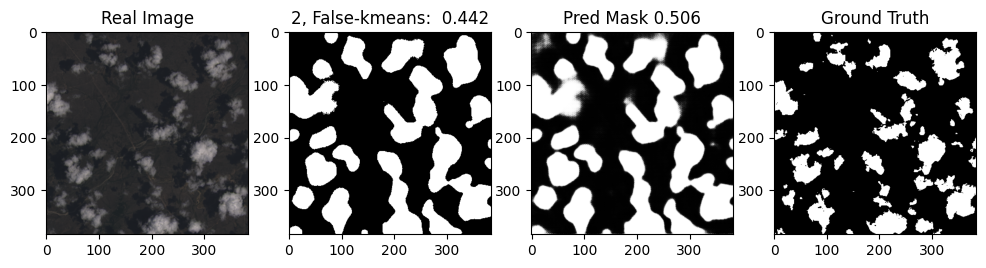

10
else condition

1/1 [==============================] - 0s 214ms/step
(147456, 32)
std=0.12592863009814323  image_mean=0.2776177645717947  image_cv=45.36043660332004 n_clusters=2
output (1, 384, 384, 1)
red  0.17575019651043808 0.28360919996468287
gr  0.17575019651043808 0.28360919996468287
bl  0.17575019651043808 0.28360919996468287
nir  0.17575019651043808 0.28360919996468287


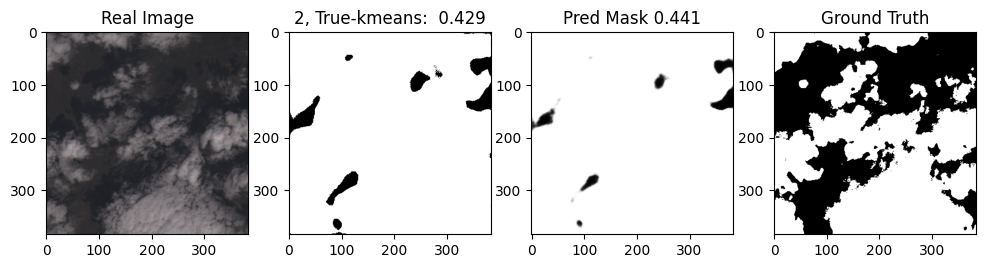

11
else condition

1/1 [==============================] - 0s 228ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


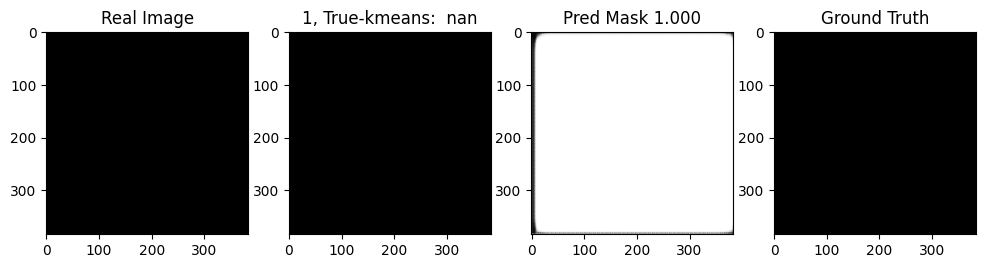

12
else condition

1/1 [==============================] - 0s 187ms/step
(147456, 32)
std=0.00806388584644566  image_mean=0.13692899019883512  image_cv=5.8891005000008105 n_clusters=1
output (1, 384, 384, 1)
red  nan 0.13692899019883512
gr  nan 0.13692899019883512
bl  nan 0.13692899019883512
nir  nan 0.13692899019883512


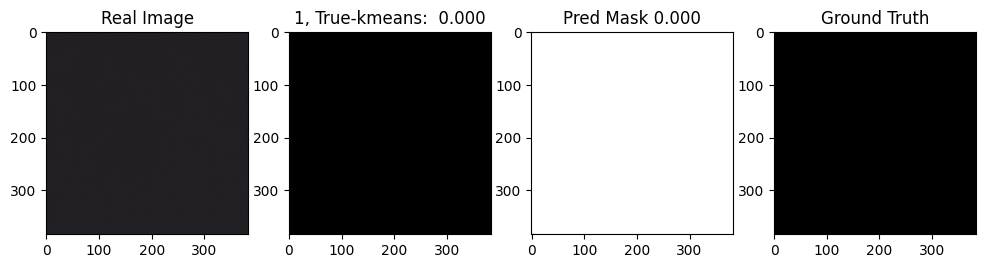

13
else condition

1/1 [==============================] - 0s 184ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


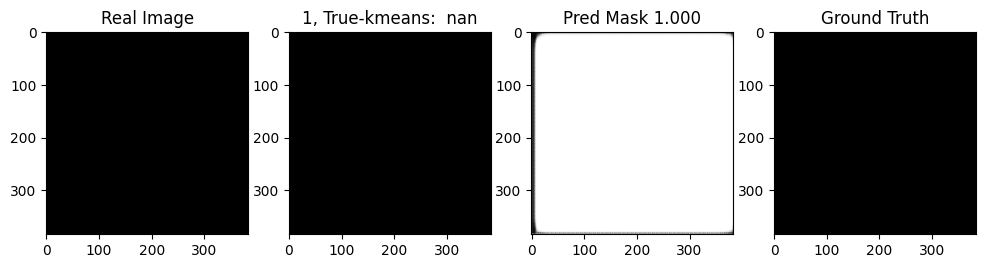

14
else condition

1/1 [==============================] - 0s 225ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


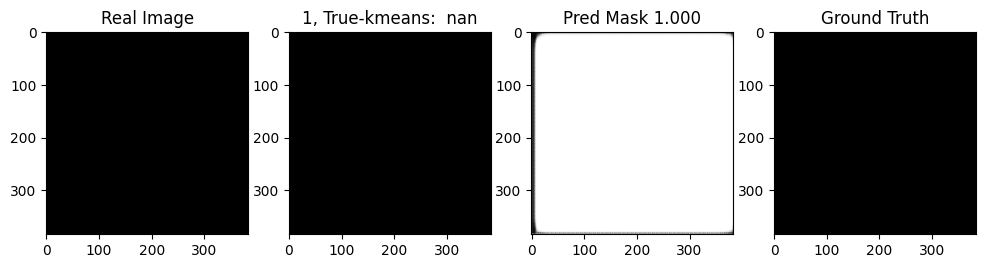

15
else condition

1/1 [==============================] - 0s 187ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


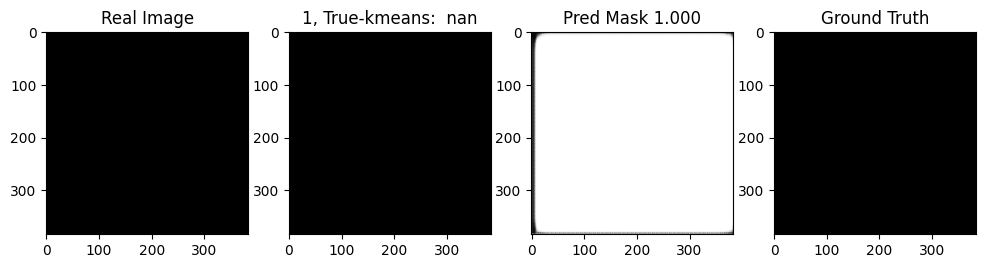

16
else condition

1/1 [==============================] - 0s 191ms/step
(147456, 32)
std=0.00797055797850039  image_mean=0.13687962339898654  image_cv=5.8230420135415155 n_clusters=1
output (1, 384, 384, 1)
red  nan 0.13687962339898654
gr  nan 0.13687962339898654
bl  nan 0.13687962339898654
nir  nan 0.13687962339898654


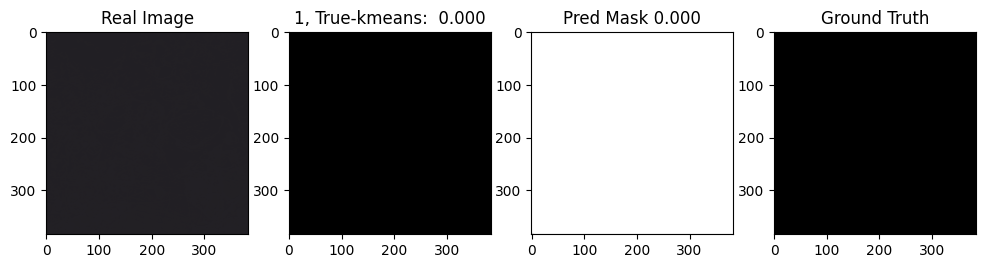

17
if condition

1/1 [==============================] - 0s 195ms/step
(109816, 32)
std=0.03838675915093383  image_mean=0.31989836634924  image_cv=833.356015003569 n_clusters=2
output (1, 384, 384, 1)
red  0.2889608302246874 0.3207562544715863
gr  0.2889608302246874 0.3207562544715863
bl  0.2889608302246874 0.3207562544715863
nir  0.2889608302246874 0.3207562544715863


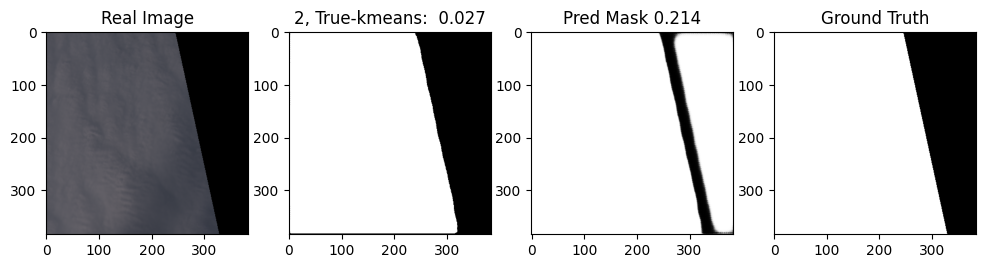

18
else condition

1/1 [==============================] - 0s 194ms/step
(147456, 32)
std=0.11844803091305948  image_mean=0.2347727773043276  image_cv=50.452199898593655 n_clusters=2
output (1, 384, 384, 1)
red  0.31800883751790376 0.1772736493552511
gr  0.31800883751790376 0.1772736493552511
bl  0.31800883751790376 0.1772736493552511
nir  0.31800883751790376 0.1772736493552511


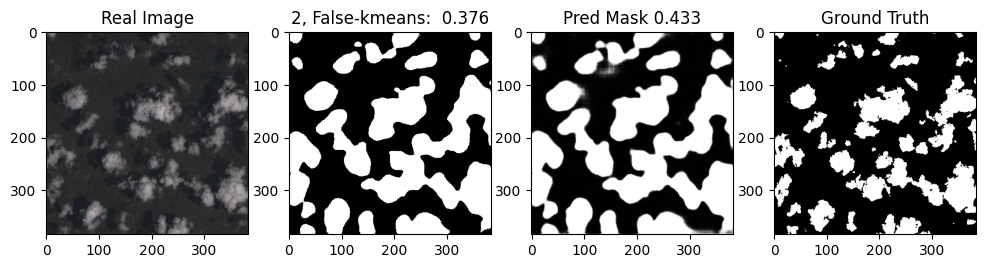

19
else condition

1/1 [==============================] - 0s 166ms/step
(147456, 32)
std=0.097272731107058  image_mean=0.19572735468368685  image_cv=49.698076829505794 n_clusters=2
output (1, 384, 384, 1)
red  0.14528613543159968 0.24903066671784074
gr  0.14528613543159968 0.24903066671784074
bl  0.14528613543159968 0.24903066671784074
nir  0.14528613543159968 0.24903066671784074


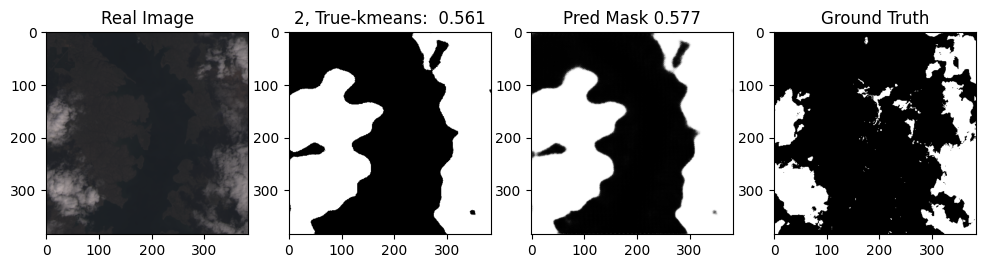

20
else condition

1/1 [==============================] - 0s 179ms/step
(147456, 32)
std=0.15105689125882316  image_mean=0.2616609434261996  image_cv=57.7300109373901 n_clusters=2
output (1, 384, 384, 1)
red  0.17780690811982236 0.41590709163520134
gr  0.17780690811982236 0.41590709163520134
bl  0.17780690811982236 0.41590709163520134
nir  0.17780690811982236 0.41590709163520134


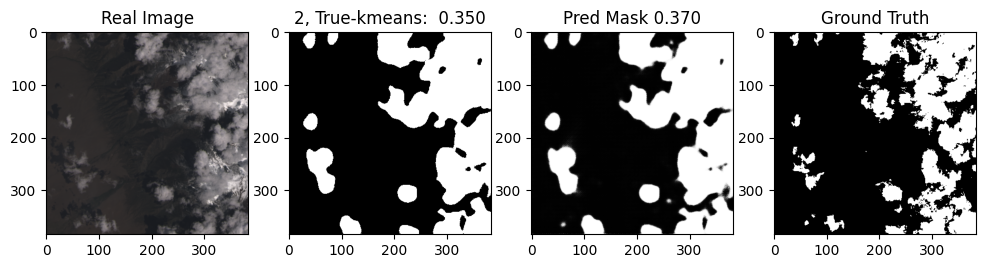

21
else condition

1/1 [==============================] - 0s 147ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


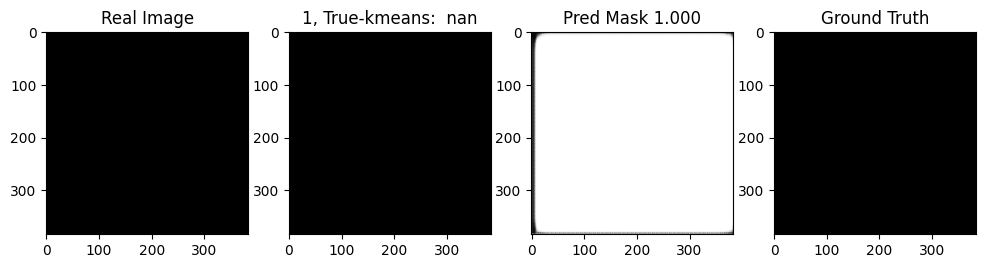

22
else condition

1/1 [==============================] - 0s 212ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


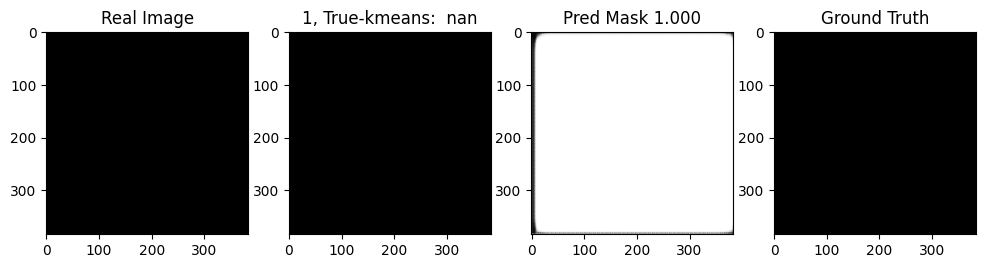

23
else condition

1/1 [==============================] - 0s 149ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


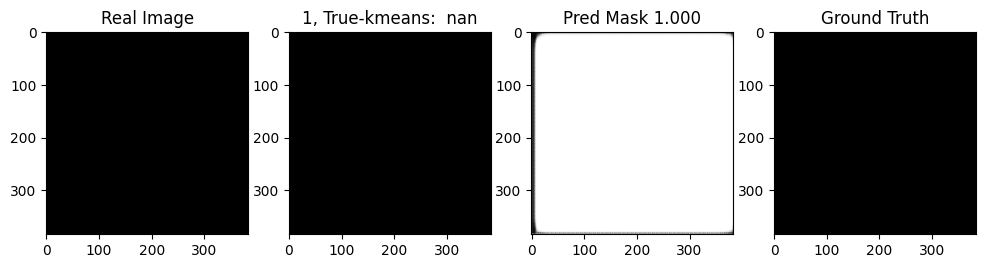

24
else condition

1/1 [==============================] - 0s 149ms/step
(147456, 32)
std=0.007967259999459474  image_mean=0.13703666760677868  image_cv=5.813962159617901 n_clusters=1
output (1, 384, 384, 1)
red  nan 0.13703666760677868
gr  nan 0.13703666760677868
bl  nan 0.13703666760677868
nir  nan 0.13703666760677868


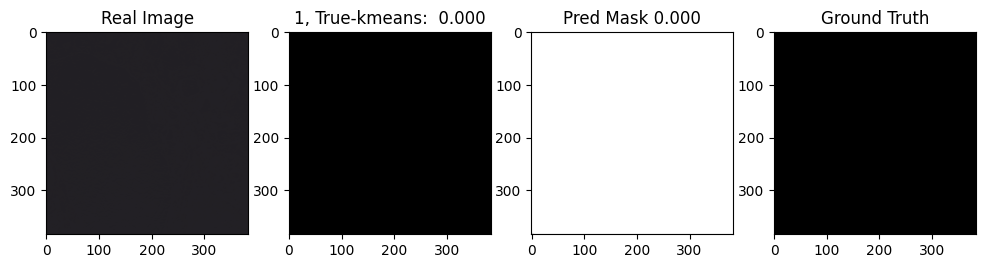

25
else condition

1/1 [==============================] - 0s 161ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


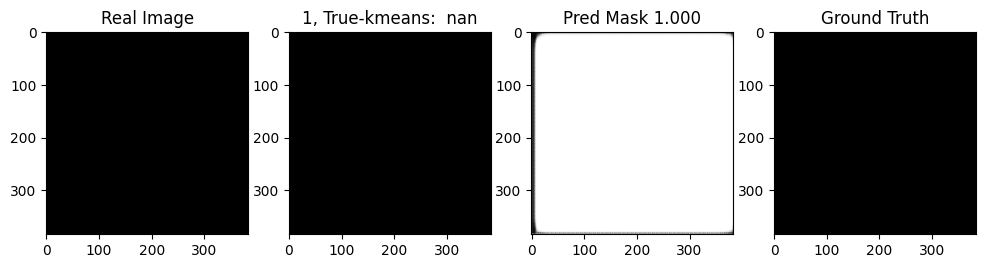

26
else condition

1/1 [==============================] - 0s 154ms/step
(147456, 32)
std=0.12192956890873914  image_mean=0.23750951432963888  image_cv=51.336709290522734 n_clusters=2
output (1, 384, 384, 1)
red  0.17707987956789345 0.32449595711525686
gr  0.17707987956789345 0.32449595711525686
bl  0.17707987956789345 0.32449595711525686
nir  0.17707987956789345 0.32449595711525686


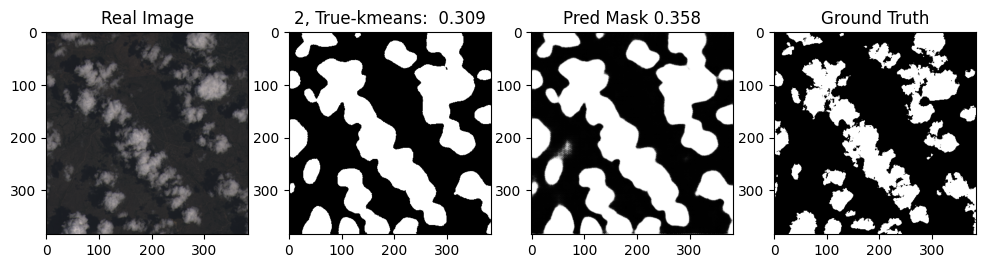

27
if condition

1/1 [==============================] - 0s 157ms/step
(130911, 32)
std=0.13466178521890848  image_mean=0.31846845475452223  image_cv=236.49504886394794 n_clusters=2
output (1, 384, 384, 1)
red  0.18961590721086502 0.32698929655933284
gr  0.18961590721086502 0.32698929655933284
bl  0.18961590721086502 0.32698929655933284
nir  0.18961590721086502 0.32698929655933284


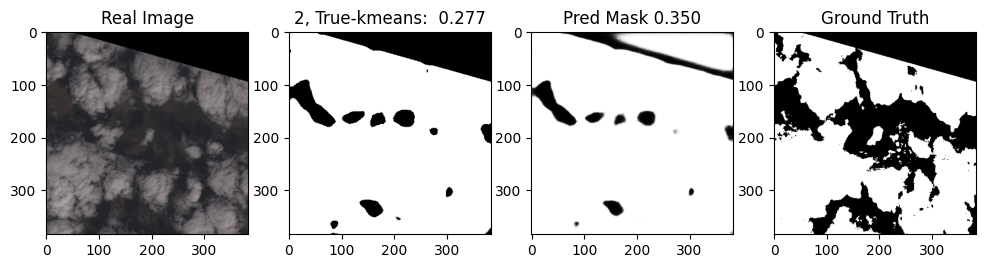

28
if condition

1/1 [==============================] - 0s 148ms/step
(146065, 32)
std=0.19365602863815332  image_mean=0.3670974603830533  image_cv=189.56159690178077 n_clusters=2
output (1, 384, 384, 1)
red  0.2488132539414297 0.3957593106192589
gr  0.2488132539414297 0.3957593106192589
bl  0.2488132539414297 0.3957593106192589
nir  0.2488132539414297 0.3957593106192589


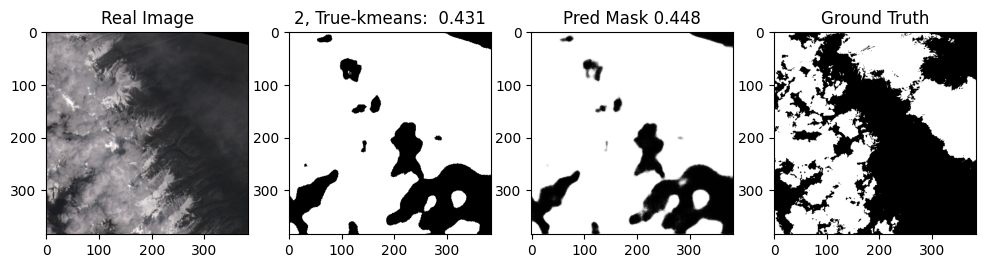

29
else condition

1/1 [==============================] - 0s 152ms/step
(147456, 32)
std=0.0  image_mean=0.0  image_cv=nan n_clusters=1
output (1, 384, 384, 1)
red  nan nan
gr  nan nan
bl  nan nan
nir  nan nan


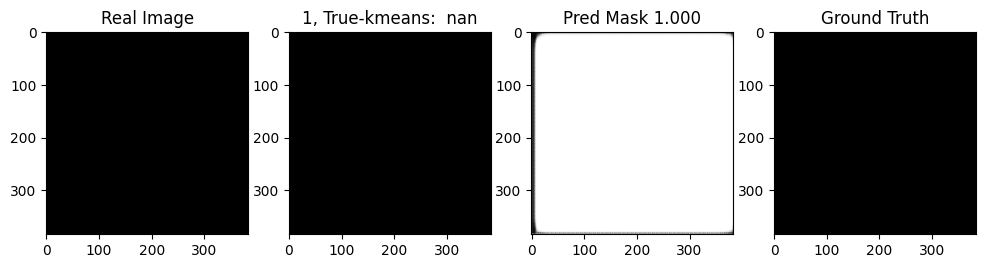

In [26]:
for i in range(0, 30):
    print(i)
    segment_image_and_display(i, train_dataset, model, newmodel)